# Reinforcement Learning, Part 3: Dealing with Non-Markov environments

Here we present a problem analogous to that faced by Redish (2004): The problem of credit assignment in a non-Markov environment.

In [2]:
## Non-markov Environment
##
##          A          Win 1.0
##        /   \      /
##  start      middle
##        \   /      \ 
##          B          Loss -1.0
##

import random
import numpy as np
import math
from copy import copy
import matplotlib.pyplot as plt

# Reward function

R = {"start" :  0,
     "A" : 0,
     "B" : 0,
     "middle" : 0,
     "win" : 1.0,
     "loss" : -1.0,
     None : 0.0
}

# State transition probability function
#
def PSS(history):
    s_current = history[-1]
    s_next = None
    
    if s_current is "start":
        coin = random.uniform(0, 1)
        if coin <= 0.5:
            s_next = "A"
        else:
            s_next = "B"
        
    elif s_current is "A" or s_current is "B":
        s_next = "middle"

    elif s_current is "middle":
        s_previous = history[-2]
        if s_previous is "A":
            s_next = "win"
        elif s_previous is "B":
            s_next = "loss"
        
    elif s_current is "win" or s_current is "loss":
        s_next = None

    return (s_next, R[s_current])
    

## The agent just passively experiences a set of states 
class Agent:
    def __init__(self, states = R.keys(), alpha = 0.1, gamma = 0.9):
        self.V = {}

        # Inits all state values to zero
        for s in states:
            self.V[s] = 0.0

        # sets the two parameters
        self.alpha = alpha
        self.gamma = gamma
        
    def td_learning(self, state1, state2, reward2):
        """Classic TD learning"""
        a = self.alpha
        g = self.gamma
        rpe = reward2 + g * self.V[state2] - self.V[state1]
        self.V[state1] += a * rpe


def plot_v_table(agent, axes, title="V-table"):
    "Plots a V-table as a bargraph"
    states = ("start", "A", "B", "middle", "win", "loss")
    values = [agent.V[state] for state in states]
        
    axes.axis([-0.5, 5.5, -1.0, 1.0])
    x = np.arange(len(states))
    axes.set_xticks(x)
    axes.set_xticklabels(states)
    axes.set_ylabel(r"Value $V$")
    axes.set_xlabel("States")
    axes.bar(x, values)
    axes.axhline(y=0, xmin=0, xmax=100, color="grey")
    axes.set_title(title)

Testing the agent cannot solve the problem

In [3]:
def rl_loop(agent, n = 1000):
    for i in range(n):
        history = ["start"]

        while PSS(history)[0] is not None:
            s_now = history[-1]
            s_next, r = PSS(history)
            history.append(s_next)
            agent.td_learning(s_now, s_next, r)

        s_now = history[-1]
        s_next, r = PSS(history)
        history.append(s_next)
        agent.td_learning(s_now, s_next, r)

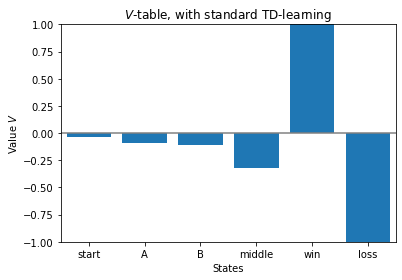

In [4]:
a = Agent()
rl_loop(a, 10000)
fig, ax = plt.subplots()
plot_v_table(a, ax, r"$V$-table, with standard TD-learning")

## The solution: Eligibility traces

In [5]:
class LambdaAgent:
    """An aget with eligibility traces and TD(lambda) learning"""
    def __init__(self, states = R.keys(), alpha = 0.1,
                 gamma = 0.9, lmbda = 0.9):
        self.V = {}
        self.E = {}
        
        # Inits all state values to zero
        for s in states:
            self.E[s] = 0.0
            self.V[s] = 0.0

        # sets the three parameters
        self.alpha = alpha
        self.gamma = gamma
        self.lmbda = lmbda
    
        
    def td_learning(self, s_now, s_next, r):
        """Learns a V-table with TD(lambda)"""
        #print("state %s, reward %.2f" % (s_now, r))
        a = self.alpha
        g = self.gamma
        l = self.lmbda
        rpe = r + g * self.V[s_next] - self.V[s_now]
        
        # First, update the trace vector
        for s in self.E.keys():
            self.E[s] *= (l * g)
            if s == s_now:
                 self.E[s] += 1

        # Second, update the V table
        for s in self.E.keys():
            self.V[s] += a * rpe * self.E[s]

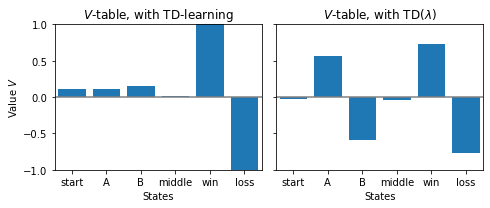

In [6]:
a = Agent()
rl_loop(a, 10000)

la = LambdaAgent()
rl_loop(la, 10000)

fig, axs = plt.subplots(1,2, figsize=(7,3))
plot_v_table(a, axs[0], r"$V$-table, with TD-learning")
plot_v_table(la, axs[1], r"$V$-table, with TD($\lambda$)")

for ax in axs.flat:
        ax.label_outer()

fig.tight_layout()
plt.savefig("figures/vtables_nonmarkov.png")

## Eligibility Traces in the Maze Example

In [7]:
class Maze():
    """A maze environment"""

    ACTIONS = ("up", "down", "left", "right") # List of actions
    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    
    def __init__(self, fname = "grid.txt"):
        """Inits a maze by loading the grid file"""
        self.grid = np.loadtxt(fname)
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state gien the "
        x, y = state1
        
        # If we have reached the cheese, we transition 
        # to the terminal state
        if self.grid[x, y] > 0:
            return None
        
        # Otherwise, we update the position
        state2 = copy(state1)
        
        if action1 in self.ACTIONS:
            if action1 == "up":
                if x > 0:
                    state2 = (x - 1, y)
            
            elif action1 == "left":
                if y > 0:
                    state2 = (x, y - 1)
            
            elif action1 == "down":
                if x < (self.grid.shape[0] - 1):
                    state2 = (x + 1, y)

            elif action1 == "right":
                if y < (self.grid.shape[1] - 1):
                    state2 = (x, y + 1)
                    
        return state2
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        if state1 == state2:
            return -1
        elif state2 == None:
            return 0
        else:
            return self.grid[state2[0], state2[1]]
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1

    
    def print_state(self):
        "Prints a text representation of the maze (with the agent position)"
        bar = "-" * ( 4 * self.grid.shape[1] + 1)
        for i in range(self.grid.shape[0]):
            row = "|"
            for j in range(self.grid.shape[1]):
                cell = " "
                if i == self.state[0] and j == self.state[1]:
                    cell = "*"
                row += (" %s |" % cell)
            print(bar)
            print(row)
        print(bar)

        
class VlambdaAgent():
    """An agent that keeps track of the value of states"""
    def __init__(self, actions=Maze.ACTIONS, alpha=0.1, 
                 gamma=0.9, lmbda = 0.8):
        """Creates a V-agent"""
        self.V = {}                # Initial dictionary of States (V-table)
        self.E = {}                # Initial dictionary of Eligibility traces
        
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.lmbda = lmbda         # Lambda decay
        
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)


    def policy(self, state):
        """Random policy to explore the maze"""
        return random.choice(self.actions)
        
    
    def td_lambda(self, state1, reward1, state2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        l = self.lmbda
        
        v1 = 0.0
        
        if state1 in self.V.keys():
            v1 = self.V[state1]
        else:
            self.V[state1] = 0.0
            self.E[state1] = 0.0
        
        v2 = 0.0
        
        if state2 in self.V.keys():
            v2 = self.V[state2]
        
        rpe = reward1 + g * v2 - v1
        
        # First, update the trace vector
        for s in self.E.keys():
            if s == state1:
                 self.E[s] += 1
            else:
                self.E[s] *= l

        # Second, update the V table
        for s in self.E.keys():
            self.V[s] += a * rpe * self.E[s]

            
def plot_v_table(agent, ax=None, title=r"$V$-table", **kwargs):
    "Plots the V table of an agent"
    if not ax:
        ax = plt.gca()

    data = np.zeros((4,4))            
            
    for s in agent.V.keys():
        x, y = s
        data[x, y] = agent.V[s]
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs, cmap="viridis")

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(range(1,5))
    ax.set_yticklabels(range(1,5))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    return im


def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1 = environment.state
    reward1 = environment.grid[state1[0], state1[1]]
    state2 = "Start"
    
    history = []
    
    while state2 != None:
        action = agent.policy(state1)
        state2, reward2 = environment.transition(action)
        history.append((state2, copy(agent.E)))
        
        # Update the V-values for state1
        agent.td_lambda(state1, reward1, state2)
        
        state1 = state2
        reward1 = reward2

    return history

    
def run_trials(environment, agent, n, collect=True):
    """Runs N trials"""
    history = []
    for j in range(n):
        h = rl_loop(environment, agent)
        history += h
        environment.state = Maze.INITIAL_STATE
    
    return history    

Text(0.5, 1.0, '$V$-Table ($t$=1000)')

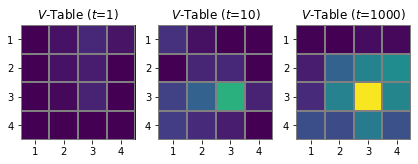

In [8]:
m = Maze()
a = VlambdaAgent(alpha=0.1)

fig, axs = plt.subplots(1, 3, figsize=(7,3))

# Because the agent moves at random, the following instruction can take a variable amount of time to complete
run_trials(m, a, 1)  
plot_v_table(a, axs[0], vmin=0, vmax=10)
axs[0].set_title(r"$V$-Table ($t$=1)")

run_trials(m, a, 9)  
plot_v_table(a, axs[1], vmin=0, vmax=10)
axs[1].set_title(r"$V$-Table ($t$=10)")

run_trials(m, a, 990)  
plot_v_table(a, axs[2], vmin=0, vmax=10)
axs[2].set_title(r"$V$-Table ($t$=1000)")

In [9]:
def plot_eligibility_traces(history, title="Traces"):
    "Plots the time course of eligibility traces over time"
    # Get eligibility traces
    E = [x[1] for x in history]
    
    # Get list of states
    res = []
    for e in E:
        res.extend(list(e.keys()))
    res.sort()

    # Remove duplicates
    S = []
    for s in res:
        if s not in S:
            S.append(s)

            
    # The X-axis
    x = range(1, len(E) + 1)
    
    # A Y-line for each state
    for s in S:
        y = []
        for e in E:
            if s in list(e.keys()):
                y.append(e[s])
            else:
                y.append(0.0)
        plt.plot(x, y)
    
    # Update state coordinates for proper lagend
    R = []
    for x, y in S:
        R.append((x + 1, y + 1))
    plt.legend(R)
    
    plt.xlabel(r"Time $t$")
    plt.ylabel("Eligibility value")
    plt.title(title)

    
def plot_state(maze, ax=None, position = None, agent=True, reward=True, 
               title="Current State", **kwargs):
    """Visualizes the maze, the rewards, and the agent's position"""
    
    if not ax:
        ax = plt.gca()

    nrows, ncols = maze.grid.shape
    data = np.zeros((nrows, ncols))            
            
    im = ax.imshow(data, **kwargs, cmap="Greys")

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(range(1, ncols + 1))
    ax.set_yticklabels(range(1, nrows + 1))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    
    if reward:
        for i in range(ncols):
            for j in range(nrows):
                r = maze.grid[j, i]
                color = None
                if r > 0:
                    color = "#EE111144"
                elif r < 0:
                    color = "#1111EE44"
                else:
                    color = "#11111144"
                text = ax.text(i, j, "%d" % (r,),
                               ha="center", va="top", color=color)
    
    if agent:
        if position is None:
            position = maze.state
        x, y = position
        text = ax.text(y, x, r"A", size="larger", weight="bold",
                       ha="center", va="bottom", color="k")
    
    return im
                
    
def plot_history_sequence(maze, history, shape=None, **kwargs):
    "Plots a sequence of moves in the grid as a set 'movie' of maze positions"
    N = len(history)
    ncols = 0
    nrows = 0
    if shape is None:
        side = math.ceil(math.sqrt(N))
        if side * (side - 1) > N:
            ncols = side 
            nrows = side - 1
        else:
            ncols = side
            nrows = side
    
    fig, axs = plt.subplots(nrows, ncols, figsize = (ncols * 2, nrows * 2))
    for ax in axs.flatten():
        ax.label_outer()
    for y in range(ncols):
        for x in range(nrows):
            ii = x * ncols + y
            if ii < N:
                plot_state(maze, ax=axs[x, y], position=history[ii], title=r"$t=%d$" % (ii + 1,))
            else:
                axs[x, y].axis('off')
    fig.tight_layout()

## Visualize eligibility traces in a Maze

The following plot shows the eligibility traces associated with each maze cell visited by the agent in an initial run.

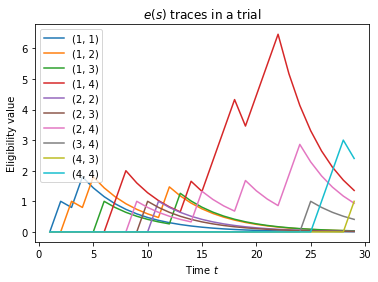

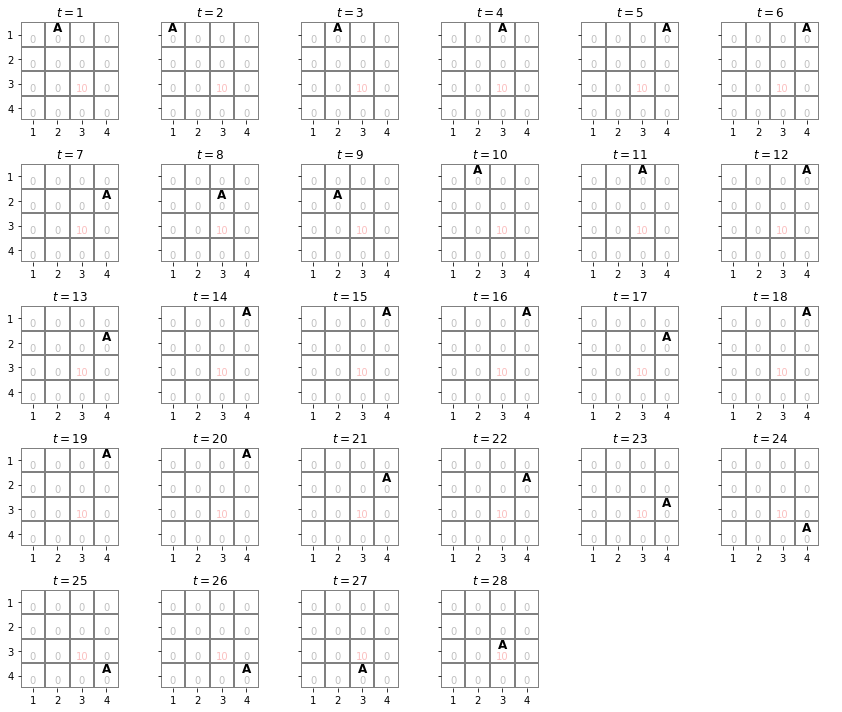

In [10]:
m = Maze()
a = VlambdaAgent(alpha=0.1)
h = run_trials(m, a, 1)  
#print(h)
plot_eligibility_traces(h, r"$e(s)$ traces in a trial")
plt.savefig("figures/traces.png")

# Print move by move
h = [x[0] for x in h]
#print(h)
plot_history_sequence(m, h[:-1])
plt.savefig("figures/traces_history.png")

## Eligibility Traces in the Maze Example, with SARSA

In [11]:
class QlambdaAgent():
    def __init__(self, actions=Maze.ACTIONS, epsilon=0.1, 
                 alpha=0.1, gamma=0.9, lmbda=0.9, method="SARSA"):
        """Creates a Q-agent"""
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.E = {}
        
        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.lmbda = lmbda         # decay rate
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)
        self.method = method
        
    def policy(self, state):
        """Selects an action with a epsilon-greedy policy"""
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

        
    def sarsa_lambda(self, state1, action1, reward1, state2, action2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        l = self.lmbda
        
        q1 = 0.0
        q2 = 0.0
        
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        else:
            self.Q[(state1, action1)] = q1
        
        if (state2, action2) in self.Q.keys():
            q2 = self.Q[(state2, action2)]
        
        rpe = reward1 + g * q2 - q1
        
        # Update the eligibility trace table
        last_trace = (state1, action1)
        
        if last_trace not in self.E.keys():
            self.E[last_trace] = 0 
        
        for trace in self.E.keys():
            self.E[trace] *= l
            if trace == last_trace:
                 self.E[trace] += 1

        # Update the Q table
        for trace in self.E.keys():
            self.Q[trace] += a * rpe * self.E[trace]
        
    
    def learn(self, state1, action1, reward1, state2, action2):
        "Generic method for learning actions"
        if self.method == "SARSA":
            self.sarsa_lambda(state1, action1, reward1, state2, action2)
        elif self.method == "Q-learning":
            self.q_learning(state1, action1, reward1, state2)

            
def rl_loop(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1  = environment.state
    reward1 = environment.grid[state1[0], state1[1]]
    
    action1 = agent.policy(state1)
    
    history = []
    state2  = ""
    
    while state2 != None:
        # Perceive the next step 
        state2, reward2 = environment.transition(action1)
        
        # Save the states visited
        history.append(state1)
        
        # Decide the next action and complete the loop
        action2 = agent.policy(state2)
        
        # Update the Q-values for state1, action1
        agent.learn(state1, action1, reward1, state2, action2)
        
        state1 = state2
        reward1 = reward2
        action1 = action2
        
    return history


def run_trials(environment, agent, n, collect=True):
    """Runs N trials"""
    history = []
    for j in range(n):
        h = rl_loop(environment, agent)
        history += h
        environment.state = Maze.INITIAL_STATE
    
    return history    


def plot_q_table(agent, **kwargs):
    """Visualizes the Q tables, one per action"""
    fig, axs = plt.subplots(2, 2, figsize=(5,5))
    i = 0
    for a in agent.actions:
        # Create the corresponding state table
        data = np.zeros((4,4))
        states = [x for x in agent.Q.keys() if x[1] == a]
            
        for s in states:
            x, y = s[0]
            data[x, y] = agent.Q[s]
        
        # Plot the heatmap
        im = axs.flat[i].imshow(data, **kwargs, cmap="viridis")

        # Create colorbar
        #cbar = ax.figure.colorbar(im, ax=ax)
        #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

        # We want to show all ticks...
        axs.flat[i].set_xticks(np.arange(data.shape[1]))
        axs.flat[i].set_yticks(np.arange(data.shape[0]))
        axs.flat[i].set_xticklabels(range(1,5))
        axs.flat[i].set_yticklabels(range(1,5))

        # Let the horizontal axes labeling appear on top.
        axs.flat[i].tick_params(top=False, bottom=True,
                                labeltop=False, labelbottom=True)

        # Turn spines off and create white grid.
        for edge, spine in axs.flat[i].spines.items():
            spine.set_visible(False)

        axs.flat[i].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        axs.flat[i].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        axs.flat[i].grid(which="minor", color="grey", linestyle='-', linewidth=2)
        axs.flat[i].tick_params(which="minor", bottom=False, left=False)
        axs.flat[i].set_title(r"$Q$-values for '%s'" % (a,))

        i += 1
    
    for ax in axs.flat:
        ax.label_outer()

    fig.subplots_adjust(right=0.85, hspace=0.2)
    cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    #fig.tight_layout()
            

def plot_history(history, ax=None, title="History", 
                 cbarlabel="Probability Visited", **kwargs):
    if not ax:
        ax = plt.gca()

    data = np.zeros((4,4))            
    for s in history:
        x, y = s
        data[x, y] += 1
    
    data /= np.max(data)
    
    # Plot the heatmap
    im = ax.imshow(data, **kwargs, cmap="Reds")

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    
    ax.set_xticklabels(range(1,5))
    ax.set_yticklabels(range(1,5))

    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)
    
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(title)
    return im, cbar


def plot_history_sequence(maze, history, shape=None, **kwargs):
    "Plots a sequence of moves in the grid as a set 'movie' of maze positions"
    N = len(history)
    ncols = 0
    nrows = 0
    if shape is None:
        side = math.ceil(math.sqrt(N))
        if side * (side - 1) > N:
            ncols = side 
            nrows = side - 1
        else:
            ncols = side
            nrows = side
    
    fig, axs = plt.subplots(nrows, ncols, figsize = (ncols * 2, nrows * 2))
    for ax in axs.flatten():
        ax.label_outer()
    for y in range(ncols):
        for x in range(nrows):
            ii = x * ncols + y
            if ii < N:
                plot_state(maze, ax=axs[x, y], position=history[ii], title=r"$t=%d$" % (ii + 1,))
            else:
                axs[x, y].axis('off')
    fig.tight_layout()

## $Q$-table when learning with eligibility traces

Because the eligibility traces allow for $\delta_t$ to back-propagate in time faster, the $Q$ table is populated much faster when eligibility traces are used.

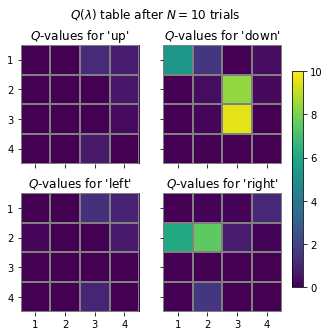

In [13]:
N = 10
m = Maze()
a = QlambdaAgent(epsilon = 0.1)
run_trials(m, a, 10)
plot_q_table(a, vmin=0, vmax=10)
plt.suptitle(r"$Q(\lambda)$ table after $N=%d$ trials" % (N,))
plt.savefig("figures/qlambdatable.png")